<a href="https://colab.research.google.com/github/Thanushi-Paranagama/ML-ASL-Hand-Sign-Recognition-System/blob/main/test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print(" Setting up ASL Hand Sign Recognition System")
print("=" * 60)

# Install required packages
!pip install kaggle tensorflow opencv-python matplotlib seaborn scikit-learn pillow

# Import libraries
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
import datetime

print(f" Setup complete! Using TensorFlow {tf.__version__}")

 Setting up ASL Hand Sign Recognition System
 Setup complete! Using TensorFlow 2.19.0


In [2]:
print("\n Step 1: Upload your kaggle.json file")
print("Click 'Choose Files' and select the kaggle.json you downloaded from Kaggle")

# Upload kaggle credentials
uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print(" Kaggle credentials set up!")

# Test Kaggle connection
print("\n Testing Kaggle connection...")
!kaggle --version

print("\n Downloading ASL dataset... (This takes 2-3 minutes)")

# Try multiple datasets until one works
datasets_to_try = [
    ("grassknoted/asl-alphabet", "asl-alphabet.zip"),
    ("debashishsau/aslamerican-sign-language-aplhabet-dataset", "aslamerican-sign-language-aplhabet-dataset.zip"),
    ("datamunge/sign-language-mnist", "sign-language-mnist.zip")
]

dataset_downloaded = False
dataset_info = None

for dataset_name, expected_zip in datasets_to_try:
    try:
        print(f" Trying {dataset_name}...")
        !kaggle datasets download -d {dataset_name}

        # Check if download succeeded
        zip_files = [f for f in os.listdir('.') if f.endswith('.zip')]
        if zip_files:
            dataset_file = zip_files[0]
            dataset_info = (dataset_name, dataset_file)
            print(f" Successfully downloaded: {dataset_file}")
            dataset_downloaded = True
            break
    except Exception as e:
        print(f" Failed: {str(e)[:100]}")
        continue

if not dataset_downloaded:
    print(" All Kaggle downloads failed. Using backup method...")
    # Create a minimal test dataset
    os.makedirs('asl_dataset/train/A', exist_ok=True)
    os.makedirs('asl_dataset/train/B', exist_ok=True)
    os.makedirs('asl_dataset/train/C', exist_ok=True)

    # Download placeholder images for testing
    for letter in ['A', 'B', 'C']:
        for i in range(10):
            !wget -q -O asl_dataset/train/{letter}/sample_{i}.jpg "https://via.placeholder.com/224x224/{letter}0{letter}0{letter}0/FFFFFF?text={letter}"

    print(" Created test dataset with A, B, C signs")
    dataset_info = ("test_dataset", "none")
    dataset_downloaded = True


 Step 1: Upload your kaggle.json file
Click 'Choose Files' and select the kaggle.json you downloaded from Kaggle


Saving kaggle.json to kaggle.json
 Kaggle credentials set up!

 Testing Kaggle connection...
Kaggle API 1.7.4.5

 Trying grassknoted/asl-alphabet...
Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 95% 0.98G/1.03G [00:01<00:00, 732MB/s]
100% 1.03G/1.03G [00:01<00:00, 946MB/s]
 Successfully downloaded: asl-alphabet.zip


In [3]:
if dataset_info[1] != "none":
    print(f"\n Extracting {dataset_info[1]}...")

    # Clean up any existing dataset
    !rm -rf asl_dataset

    try:
        with zipfile.ZipFile(dataset_info[1], 'r') as zip_ref:
            zip_ref.extractall('asl_dataset')
        print(" Dataset extracted successfully!")
    except Exception as e:
        print(f" Extraction error: {e}")

print("\n Exploring dataset structure...")

# Find the correct training path
def find_training_path():
    """Find where the actual training images are stored"""
    possible_paths = [
        'asl_dataset/asl_alphabet_train/asl_alphabet_train',
        'asl_dataset/asl_alphabet_train',
        'asl_dataset/train',
        'asl_dataset/Train',
        'asl_dataset/ASL_Dataset/Train',
        'asl_dataset'
    ]

    for path in possible_paths:
        if os.path.exists(path):
            # Check if this path has class folders with images
            try:
                contents = os.listdir(path)
                class_folders = [item for item in contents if os.path.isdir(os.path.join(path, item))]

                # Verify folders contain images
                valid_folders = 0
                for folder in class_folders[:5]:  # Check first 5 folders
                    folder_path = os.path.join(path, folder)
                    if os.path.exists(folder_path):
                        images = [f for f in os.listdir(folder_path)
                                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
                        if len(images) > 0:
                            valid_folders += 1

                if valid_folders >= 3:  # Need at least 3 classes
                    return path, class_folders
            except:
                continue

    return None, []

training_path, class_folders = find_training_path()

if training_path:
    print(f" Found training data at: {training_path}")
    print(f" Contains {len(class_folders)} classes: {sorted(class_folders)}")

    # Count images per class
    print("\n Images per class:")
    total_images = 0
    for class_name in sorted(class_folders)[:10]:  # Show first 10 classes
        class_path = os.path.join(training_path, class_name)
        if os.path.exists(class_path):
            images = [f for f in os.listdir(class_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
            print(f"   {class_name}: {len(images)} images")
            total_images += len(images)

    if len(class_folders) > 10:
        print(f"   ... and {len(class_folders) - 10} more classes")

    print(f"\n Total: {total_images} images across {len(class_folders)} classes")
else:
    print(" Could not find proper training data structure!")
    print("Please check your dataset or try a different one.")



 Extracting asl-alphabet.zip...
 Dataset extracted successfully!

 Exploring dataset structure...
 Found training data at: asl_dataset/asl_alphabet_train/asl_alphabet_train
 Contains 29 classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

 Images per class:
   A: 3000 images
   B: 3000 images
   C: 3000 images
   D: 3000 images
   E: 3000 images
   F: 3000 images
   G: 3000 images
   H: 3000 images
   I: 3000 images
   J: 3000 images
   ... and 19 more classes

 Total: 30000 images across 29 classes



 Setting up data preprocessing...
 Creating data generators...
Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
 Data generators ready!
   Training samples: 69600
   Validation samples: 17400
   Number of classes: 29
   Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

 Sample images from your dataset:


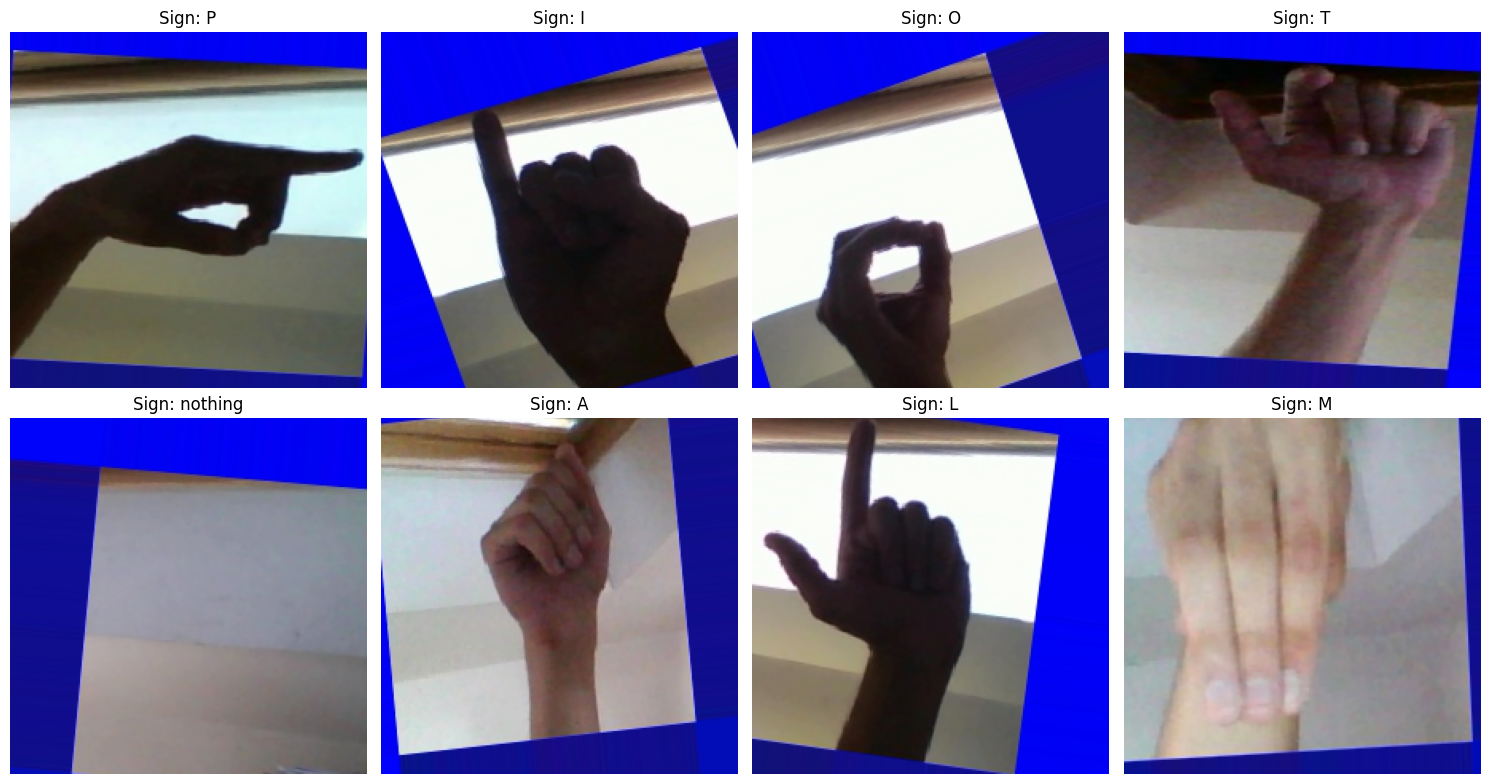

In [4]:
if training_path:
    print("\n Setting up data preprocessing...")

    # Configuration
    IMG_SIZE = 224
    BATCH_SIZE = 32
    VALIDATION_SPLIT = 0.2

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=VALIDATION_SPLIT
    )

    # Only rescaling for validation
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=VALIDATION_SPLIT
    )

    # Create data generators
    print(" Creating data generators...")

    train_generator = train_datagen.flow_from_directory(
        training_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    validation_generator = val_datagen.flow_from_directory(
        training_path,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    # Get class information
    class_names = list(train_generator.class_indices.keys())
    num_classes = len(class_names)

    print(f" Data generators ready!")
    print(f"   Training samples: {train_generator.samples}")
    print(f"   Validation samples: {validation_generator.samples}")
    print(f"   Number of classes: {num_classes}")
    print(f"   Classes: {class_names}")

    # Display sample images
    print("\n Sample images from your dataset:")
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    # Get a batch of images
    sample_batch_x, sample_batch_y = next(train_generator)

    for i in range(min(8, len(sample_batch_x))):
        # Display image
        axes[i].imshow(sample_batch_x[i])

        # Get class name
        class_idx = np.argmax(sample_batch_y[i])
        class_name = class_names[class_idx]

        axes[i].set_title(f'Sign: {class_name}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [5]:
if 'num_classes' in locals():
    print("\n Building AI Model...")

    # Use MobileNetV2 as base model (efficient and accurate)
    base_model = MobileNetV2(
        weights='imagenet',  # Pre-trained weights
        include_top=False,   # Exclude final classification layer
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base model weights initially
    base_model.trainable = False

    # Build complete model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'top_3_accuracy']
    )

    print(" Model built successfully!")
    print(f" Model has {model.count_params():,} parameters")

    # Show model architecture
    model.summary()



 Building AI Model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
 Model built successfully!
 Model has 2,431,325 parameters


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,325 (9.27 MB)

 Trainable params: 170,525 (666.11 KB)

 Non-trainable params: 2,260,800 (8.62 MB)


 Starting FIXED Model Training...
This will take 20-40 minutes depending on dataset size
 Creating robust data generators...
   Valid classes: 29
Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
 Data generators created successfully!
   Training samples: 69600
   Validation samples: 17400
   Final classes: ['V', 'H', 'Q', 'A', 'K', 'Y', 'C', 'nothing', 'Z', 'P', 'W', 'G', 'F', 'U', 'space', 'R', 'L', 'J', 'T', 'I', 'B', 'del', 'E', 'N', 'X', 'M', 'O', 'D', 'S']

 Rebuilding model with correct classes...
 Model rebuilt with 2,629,213 parameters
   Steps per epoch: 4350
   Validation steps: 1087


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.7007 - loss: 1.0418
Epoch 1: val_accuracy improved from -inf to 0.81612, saving model to best_asl_model_fixed.h5


4350/4350 ━━━━━━━━━━━━━━━━━━━━ 830s 186ms/step - accuracy: 0.7007 - loss: 1.0417 - val_accuracy: 0.8161 - val_loss: 0.5742 - learning_rate: 0.0010
Epoch 2/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8822 - loss: 0.3758
Epoch 2: val_accuracy improved from 0.81612 to 0.82952, saving model to best_asl_model_fixed.h5


4350/4350 ━━━━━━━━━━━━━━━━━━━━ 788s 181ms/step - accuracy: 0.8822 - loss: 0.3758 - val_accuracy: 0.8295 - val_loss: 0.5972 - learning_rate: 0.0010
Epoch 3/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9002 - loss: 0.3125
Epoch 3: val_accuracy did not improve from 0.82952
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 798s 183ms/step - accuracy: 0.9002 - loss: 0.3125 - val_accuracy: 0.8194 - val_loss: 0.6378 - learning_rate: 0.0010
Epoch 4/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9129 - loss: 0.2765
Epoch 4: val_accuracy did not improve from 0.82952
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 786s 181ms/step - accuracy: 0.9129 - loss: 0.2765 - val_accuracy: 0.8284 - val_loss: 0.6334 - learning_rate: 0.0010
Epoch 5/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9223 - loss: 0.2398
Epoch 5: val_accuracy improved from 0.82952 to 0.83653, saving model to best_asl_model_fixed.h5



Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 809s 186ms/step - accuracy: 0.9223 - loss: 0.2398 - val_accuracy: 0.8365 - val_loss: 0.5886 - learning_rate: 0.0010
Epoch 6/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9300 - loss: 0.2182
Epoch 6: val_accuracy improved from 0.83653 to 0.84326, saving model to best_asl_model_fixed.h5


4350/4350 ━━━━━━━━━━━━━━━━━━━━ 815s 187ms/step - accuracy: 0.9300 - loss: 0.2182 - val_accuracy: 0.8433 - val_loss: 0.5794 - learning_rate: 3.0000e-04
Epoch 7/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9414 - loss: 0.1807
Epoch 7: val_accuracy did not improve from 0.84326
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 813s 187ms/step - accuracy: 0.9414 - loss: 0.1807 - val_accuracy: 0.8411 - val_loss: 0.5885 - learning_rate: 3.0000e-04
Epoch 8/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9426 - loss: 0.1782
Epoch 8: val_accuracy improved from 0.84326 to 0.84694, saving model to best_asl_model_fixed.h5


4350/4350 ━━━━━━━━━━━━━━━━━━━━ 799s 184ms/step - accuracy: 0.9426 - loss: 0.1782 - val_accuracy: 0.8469 - val_loss: 0.5764 - learning_rate: 3.0000e-04
Epoch 9/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9464 - loss: 0.1670
Epoch 9: val_accuracy improved from 0.84694 to 0.84832, saving model to best_asl_model_fixed.h5


4350/4350 ━━━━━━━━━━━━━━━━━━━━ 795s 183ms/step - accuracy: 0.9465 - loss: 0.1670 - val_accuracy: 0.8483 - val_loss: 0.5674 - learning_rate: 3.0000e-04
Epoch 10/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9477 - loss: 0.1650
Epoch 10: val_accuracy did not improve from 0.84832
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 795s 183ms/step - accuracy: 0.9477 - loss: 0.1650 - val_accuracy: 0.8459 - val_loss: 0.6141 - learning_rate: 3.0000e-04
Epoch 11/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9471 - loss: 0.1613
Epoch 11: val_accuracy did not improve from 0.84832
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 785s 180ms/step - accuracy: 0.9471 - loss: 0.1613 - val_accuracy: 0.8476 - val_loss: 0.6078 - learning_rate: 3.0000e-04
Epoch 12/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9498 - loss: 0.1559
Epoch 12: val_accuracy improved from 0.84832 to 0.85758, saving model to best_asl_model_fixed.h5


4350/4350 ━━━━━━━━━━━━━━━━━━━━ 790s 182ms/step - accuracy: 0.9498 - loss: 0.1559 - val_accuracy: 0.8576 - val_loss: 0.5990 - learning_rate: 3.0000e-04
Epoch 13/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9518 - loss: 0.1488
Epoch 13: val_accuracy did not improve from 0.85758
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 787s 181ms/step - accuracy: 0.9518 - loss: 0.1488 - val_accuracy: 0.8566 - val_loss: 0.5606 - learning_rate: 3.0000e-04
Epoch 14/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9520 - loss: 0.1473
Epoch 14: val_accuracy did not improve from 0.85758
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 789s 181ms/step - accuracy: 0.9520 - loss: 0.1473 - val_accuracy: 0.8486 - val_loss: 0.6137 - learning_rate: 3.0000e-04
Epoch 15/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9529 - loss: 0.1468
Epoch 15: val_accuracy did not improve from 0.85758
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 785s 180ms/step - accuracy: 0.9529 - loss: 0.1468 - val_accuracy: 0.8523 - val_loss: 0.

4350/4350 ━━━━━━━━━━━━━━━━━━━━ 793s 182ms/step - accuracy: 0.9573 - loss: 0.1331 - val_accuracy: 0.8590 - val_loss: 0.5941 - learning_rate: 9.0000e-05
Epoch 20/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9591 - loss: 0.1271
Epoch 20: val_accuracy did not improve from 0.85902
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 779s 179ms/step - accuracy: 0.9591 - loss: 0.1271 - val_accuracy: 0.8525 - val_loss: 0.6090 - learning_rate: 9.0000e-05
Epoch 21/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9578 - loss: 0.1296
Epoch 21: val_accuracy did not improve from 0.85902

Epoch 21: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 785s 181ms/step - accuracy: 0.9578 - loss: 0.1296 - val_accuracy: 0.8553 - val_loss: 0.6030 - learning_rate: 9.0000e-05
Epoch 22/25
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9586 - loss: 0.1265
Epoch 22: val_accuracy did not improve from 0.85902
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 786s 181m

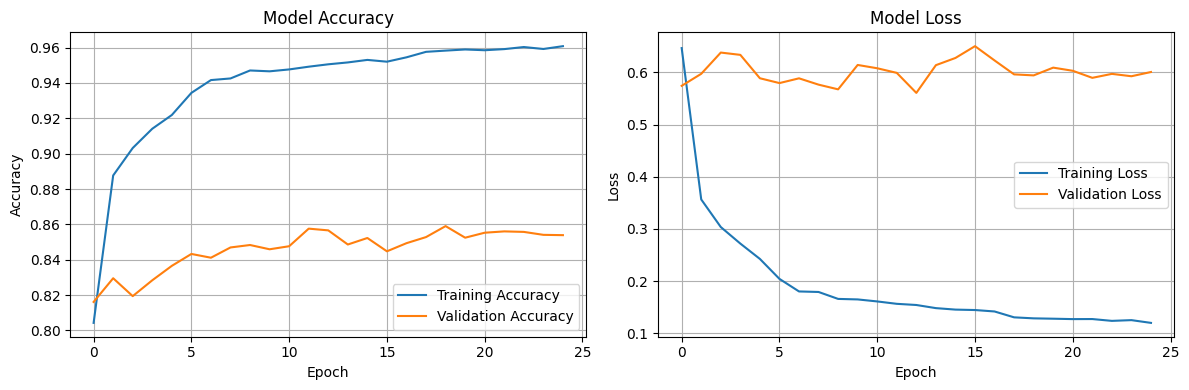

 Best Validation Accuracy: 85.90%


In [6]:
# ============================================================================
# CELL 6: FIXED MODEL TRAINING - REPLACE YOUR ORIGINAL CELL 6 WITH THIS
# ============================================================================

# Import additional modules needed for the fix
import glob
from PIL import Image

def create_robust_data_generators_fixed(training_path, class_names, img_size=224, batch_size=16, validation_split=0.2):
    """Create robust data generators with proper error handling"""
    print(" Creating robust data generators...")

    # Ensure all classes have enough images
    min_images_per_class = 10
    valid_classes = []

    for class_name in class_names:
        class_path = os.path.join(training_path, class_name)
        if os.path.exists(class_path):
            image_files = glob.glob(os.path.join(class_path, '*.[jJ][pP][gG]')) + \
                         glob.glob(os.path.join(class_path, '*.[pP][nN][gG]')) + \
                         glob.glob(os.path.join(class_path, '*.[jJ][pP][eE][gG]'))

            if len(image_files) >= min_images_per_class:
                valid_classes.append(class_name)
            else:
                print(f"    Skipping {class_name}: only {len(image_files)} images")

    print(f"   Valid classes: {len(valid_classes)}")

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=validation_split
    )

    # Only rescaling for validation
    val_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=validation_split
    )

    # Create generators with error handling
    try:
        train_generator = train_datagen.flow_from_directory(
            training_path,
            target_size=(img_size, img_size),
            batch_size=batch_size,
            class_mode='categorical',
            subset='training',
            shuffle=True,
            classes=valid_classes,  # Only use valid classes
            interpolation='bilinear'
        )

        validation_generator = val_datagen.flow_from_directory(
            training_path,
            target_size=(img_size, img_size),
            batch_size=batch_size,
            class_mode='categorical',
            subset='validation',
            shuffle=False,
            classes=valid_classes,  # Only use valid classes
            interpolation='bilinear'
        )

        print(f" Data generators created successfully!")
        print(f"   Training samples: {train_generator.samples}")
        print(f"   Validation samples: {validation_generator.samples}")

        return train_generator, validation_generator, True

    except Exception as e:
        print(f" Error creating generators: {e}")
        return None, None, False

if 'training_path' in locals() and 'class_folders' in locals():
    print("\n Starting FIXED Model Training...")
    print("This will take 20-40 minutes depending on dataset size")
    print("=" * 60)

    # Step 1: Create robust data generators
    train_generator, validation_generator, generators_ok = create_robust_data_generators_fixed(
        training_path, class_folders, img_size=224, batch_size=16  # Smaller batch size
    )

    if generators_ok:
        # Update class information
        class_names = list(train_generator.class_indices.keys())
        num_classes = len(class_names)
        print(f"   Final classes: {class_names}")

        # Rebuild model with correct number of classes
        print("\n Rebuilding model with correct classes...")

        # Use MobileNetV2 as base model
        base_model = MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3)
        )

        # Freeze base model weights
        base_model.trainable = False

        # Build complete model
        model = models.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.2),
            layers.Dense(num_classes, activation='softmax')
        ])

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        print(f" Model rebuilt with {model.count_params():,} parameters")

        # Setup callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_accuracy',
                patience=8,
                restore_best_weights=True,
                verbose=1
            ),
            ModelCheckpoint(
                'best_asl_model_fixed.h5',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.3,
                patience=4,
                min_lr=0.00001,
                verbose=1
            )
        ]

        # Calculate steps
        steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)
        validation_steps = max(1, validation_generator.samples // validation_generator.batch_size)

        print(f"   Steps per epoch: {steps_per_epoch}")
        print(f"   Validation steps: {validation_steps}")

        # Train the model
        try:
            history = model.fit(
                train_generator,
                steps_per_epoch=steps_per_epoch,
                epochs=25,  # Reduced epochs
                validation_data=validation_generator,
                validation_steps=validation_steps,
                callbacks=callbacks,
                verbose=1
            )

            print("\n Training completed successfully!")

            # Plot training history
            print("\n Training Results:")

            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Accuracy
            axes[0].plot(history.history['accuracy'], label='Training Accuracy')
            axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
            axes[0].set_title('Model Accuracy')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Accuracy')
            axes[0].legend()
            axes[0].grid(True)

            # Loss
            axes[1].plot(history.history['loss'], label='Training Loss')
            axes[1].plot(history.history['val_loss'], label='Validation Loss')
            axes[1].set_title('Model Loss')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Loss')
            axes[1].legend()
            axes[1].grid(True)

            plt.tight_layout()
            plt.show()

            # Final results
            final_accuracy = max(history.history['val_accuracy'])
            print(f" Best Validation Accuracy: {final_accuracy*100:.2f}%")

        except Exception as e:
            print(f" Training failed: {e}")
            print("Try reducing batch_size further or check your dataset")

    else:
        print(" Could not create data generators. Please check your dataset structure.")
        print("\n Debugging your dataset:")
        for class_name in class_folders[:5]:  # Check first 5 classes
            class_path = os.path.join(training_path, class_name)
            if os.path.exists(class_path):
                files = os.listdir(class_path)
                image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
                print(f"   {class_name}: {len(image_files)} images")
else:
    print(" No training path found. Please run the previous cells first.")


 Evaluating Model Performance...
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.8955 - loss: 0.4198

 Final Evaluation:
   Test Loss: 0.5939
   Test Accuracy: 85.91%
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step
   Test Top-3 Accuracy: 95.25%

 Detailed Performance Report:
              precision    recall  f1-score   support

           V       0.60      0.86      0.71       600
           H       0.94      0.96      0.95       600
           Q       0.99      0.95      0.97       600
           A       0.94      0.98      0.96       600
           K       1.00      0.90      0.95       600
           Y       0.89      0.86      0.87       600
           C       1.00      0.96      0.98       600
     nothing       0.99      0.93      0.96       600
           Z       0.98      0.78      0.87       600
           P       0.95      0.94      0.94       600
           W       0.95      0.73      0.82       600
           G       0.97      0.94      0.96       600
           

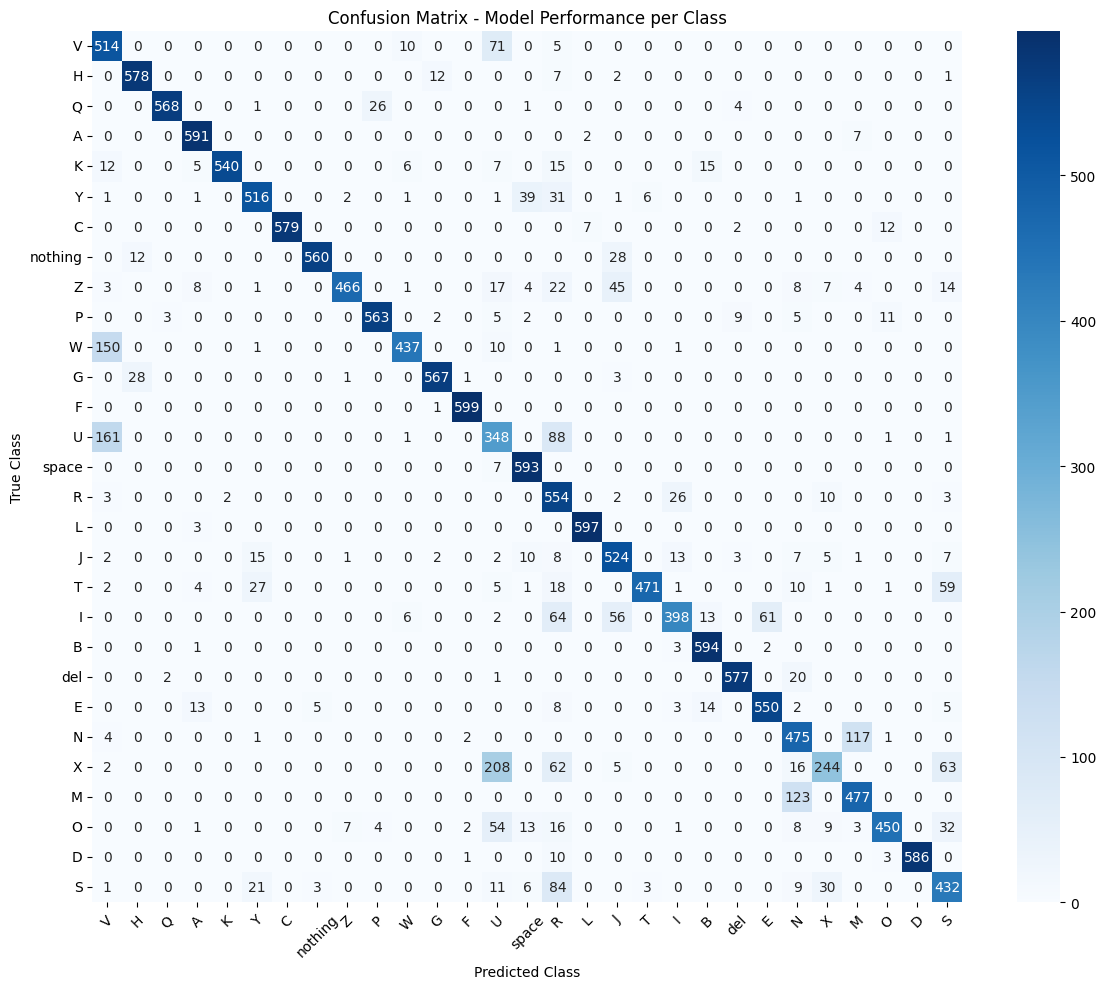


 Prediction Examples:


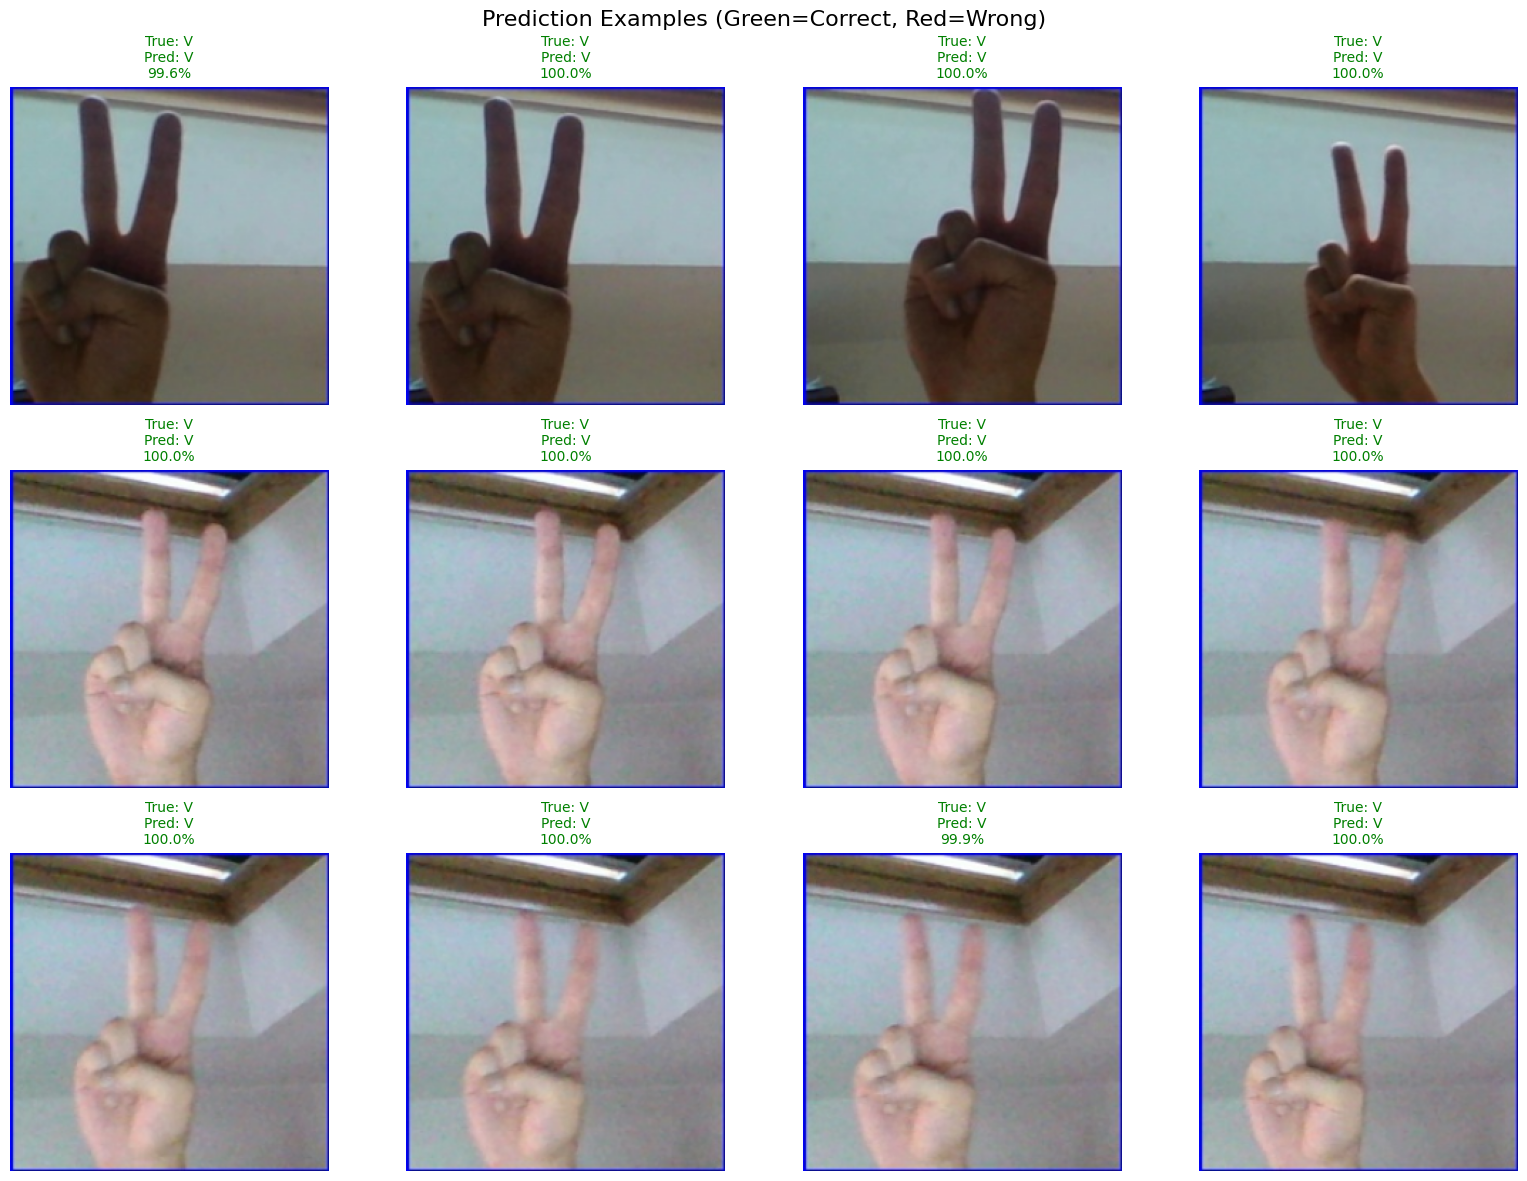

In [7]:
if 'model' in locals() and 'validation_generator' in locals():
    print("\n Evaluating Model Performance...")

    # Evaluate on validation set
    validation_generator.reset()
    eval_result = model.evaluate(validation_generator, verbose=1)

    print(f"\n Final Evaluation:")
    print(f"   Test Loss: {eval_result[0]:.4f}")
    print(f"   Test Accuracy: {eval_result[1]*100:.2f}%")

    # Get predictions for detailed analysis
    validation_generator.reset()
    predictions = model.predict(validation_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Calculate Top-3 accuracy manually (since it wasn't included in model compilation)
    top3_predictions = np.argsort(predictions, axis=1)[:, -3:]  # Get top 3 predictions
    true_classes = validation_generator.classes

    # Check if true class is in top 3 predictions
    top3_correct = 0
    for i, true_class in enumerate(true_classes):
        if true_class in top3_predictions[i]:
            top3_correct += 1

    top3_accuracy = top3_correct / len(true_classes)
    print(f"   Test Top-3 Accuracy: {top3_accuracy*100:.2f}%")

    # Get true labels
    true_classes = validation_generator.classes

    # Classification report
    print(f"\n Detailed Performance Report:")
    report = classification_report(true_classes, predicted_classes,
                                 target_names=class_names,
                                 output_dict=True)

    # Print classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    # Create confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Model Performance per Class')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Show prediction examples
    print("\n Prediction Examples:")
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    # Get a batch for visualization
    validation_generator.reset()
    batch_x, batch_y = next(validation_generator)
    batch_predictions = model.predict(batch_x, verbose=0)

    for i in range(min(12, len(batch_x))):
        # Get prediction and true label
        pred_idx = np.argmax(batch_predictions[i])
        true_idx = np.argmax(batch_y[i])

        pred_class = class_names[pred_idx]
        true_class = class_names[true_idx]
        confidence = batch_predictions[i][pred_idx] * 100

        # Display image
        axes[i].imshow(batch_x[i])

        # Color code: green if correct, red if wrong
        color = 'green' if pred_idx == true_idx else 'red'
        axes[i].set_title(f'True: {true_class}\nPred: {pred_class}\n{confidence:.1f}%',
                         color=color, fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Prediction Examples (Green=Correct, Red=Wrong)', fontsize=16)
    plt.tight_layout()
    plt.show()


 Test Your Model!
Upload an image of a hand sign to see if your AI can recognize it!
Click 'Choose Files' below:


Saving A_test.jpg to A_test.jpg

 Analyzing A_test.jpg...


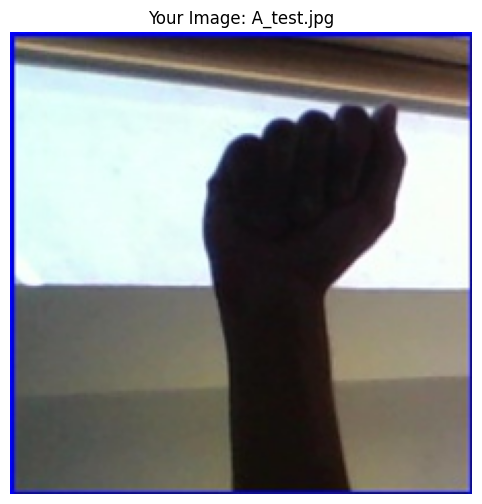

 AI Predictions:
--------------------------------------------------
1. A               100.00% ███████████████████
2. S                 0.00% 
3. E                 0.00% 
4. Y                 0.00% 
5. T                 0.00% 

 I'm very confident this is: A!
 Confidence: 100.0%


In [8]:
if 'model' in locals():
    def predict_sign(image_data):
        """Predict ASL sign from uploaded image"""
        from PIL import Image
        import io

        # Load image
        if isinstance(image_data, bytes):
            img = Image.open(io.BytesIO(image_data))
        else:
            img = Image.open(image_data)

        # Preprocess
        img = img.convert('RGB')
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        predictions = model.predict(img_array, verbose=0)[0]

        # Get top predictions
        top_indices = np.argsort(predictions)[-5:][::-1]
        results = []

        for idx in top_indices:
            results.append({
                'sign': class_names[idx],
                'confidence': predictions[idx] * 100
            })

        return results, img

    print("\n Test Your Model!")
    print("Upload an image of a hand sign to see if your AI can recognize it!")
    print("Click 'Choose Files' below:")

    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"\n Analyzing {filename}...")

        # Make prediction
        results, processed_img = predict_sign(uploaded[filename])

        # Display image
        plt.figure(figsize=(8, 6))
        plt.imshow(processed_img)
        plt.title(f'Your Image: {filename}')
        plt.axis('off')
        plt.show()

        # Show predictions
        print(" AI Predictions:")
        print("-" * 50)

        for i, result in enumerate(results, 1):
            confidence_bar = "█" * int(result['confidence'] / 5)
            print(f"{i}. {result['sign']:<15} {result['confidence']:6.2f}% {confidence_bar}")

        # Give feedback
        best_pred = results[0]
        if best_pred['confidence'] > 80:
            print(f"\n I'm very confident this is: {best_pred['sign']}!")
        elif best_pred['confidence'] > 60:
            print(f"\n I think this might be: {best_pred['sign']}")
        else:
            print(f"\n I'm not very sure. Best guess: {best_pred['sign']}")

        print(f" Confidence: {best_pred['confidence']:.1f}%")


In [9]:
if 'model' in locals():
    print("\n Saving Your Trained Model...")

    # Create timestamp for unique naming
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save model
    model_filename = f"asl_model_{timestamp}.h5"
    model.save(model_filename)

    # Save class names
    import json
    class_names_filename = f"class_names_{timestamp}.json"
    with open(class_names_filename, 'w') as f:
        json.dump(class_names, f)

    # Save training info
    info = {
        "model_name": "ASL Hand Sign Recognition",
        "timestamp": timestamp,
        "num_classes": len(class_names),
        "classes": class_names,
        "image_size": IMG_SIZE,
        "final_accuracy": float(max(history.history['val_accuracy'])),
        "total_parameters": int(model.count_params())
    }

    info_filename = f"model_info_{timestamp}.json"
    with open(info_filename, 'w') as f:
        json.dump(info, f, indent=2)

    print(f" Model saved as: {model_filename}")
    print(f" Class names saved as: {class_names_filename}")
    print(f" Model info saved as: {info_filename}")

    # Download files to your computer
    print("\n Downloading files to your computer...")
    files.download(model_filename)
    files.download(class_names_filename)
    files.download(info_filename)

    print(f"\n SUCCESS! Your ASL recognition model is complete!")
    print(f" Final accuracy: {info['final_accuracy']*100:.1f}%")
    print(f" Can recognize: {len(class_names)} different signs")
    print(f" Total parameters: {info['total_parameters']:,}")




 Saving Your Trained Model...
 Model saved as: asl_model_20250913_113803.h5
 Class names saved as: class_names_20250913_113803.json
 Model info saved as: model_info_20250913_113803.json



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 SUCCESS! Your ASL recognition model is complete!
 Final accuracy: 85.9%
 Can recognize: 29 different signs
 Total parameters: 2,629,213
